# Mango Leaf Disease Classification
This notebook demonstrates the training of a convolutional neural network (CNN) to classify mango leaf diseases. The dataset is assumed to be located in a directory named `mango`, with subdirectories for each class representing different diseases (or healthy leaves).


In [79]:
import os
import PIL
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model


## Dataset Preparation
Using a custom dataset located in the `mango` directory. The dataset must follow the required directory structure, where each class has its own subdirectory.


In [80]:
# Replace this with the path to your mango dataset directory
data_dir = pathlib.Path("./mango")

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images:", image_count)


Total number of images: 2400


## Loading Data
The data is divided into training and validation sets. 80% of the images are used for training, and 20% are reserved for validation.


In [81]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Use 20% of data for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2400 files belonging to 6 classes.
Using 1920 files for training.
Found 2400 files belonging to 6 classes.
Using 480 files for validation.


## Class Names
The classes are automatically inferred from the subdirectory names in the dataset.


In [82]:
class_names = train_ds.class_names
print("Class Names:", class_names)


Class Names: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy']


## Optimizing Dataset Performance
Cache the datasets to memory and shuffle the training dataset to improve performance during training.

In [83]:
train_ds = train_ds.cache().shuffle(1000)
val_ds = val_ds.cache()


## Building the Model
The model is a convolutional neural network with three convolutional layers, max pooling, and dense layers for classification.


In [84]:
num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

## Training the Model
Train the model for 10 epochs and validate its performance on the validation dataset.


In [85]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Training Complete!")


Epoch 1/5
60/60 [==============================] - 19s 279ms/step - loss: 1.3387 - accuracy: 0.4542 - val_loss: 0.7403 - val_accuracy: 0.7417
Epoch 2/5
60/60 [==============================] - 18s 304ms/step - loss: 0.5453 - accuracy: 0.7974 - val_loss: 0.3968 - val_accuracy: 0.8646
Epoch 3/5
60/60 [==============================] - 17s 284ms/step - loss: 0.3267 - accuracy: 0.8844 - val_loss: 0.3631 - val_accuracy: 0.8604
Epoch 4/5
60/60 [==============================] - 21s 352ms/step - loss: 0.2284 - accuracy: 0.9250 - val_loss: 0.2651 - val_accuracy: 0.9021
Epoch 5/5
60/60 [==============================] - 18s 296ms/step - loss: 0.1501 - accuracy: 0.9484 - val_loss: 0.3047 - val_accuracy: 0.8833
Training Complete!


## Visualizing Training Results
The training and validation accuracy and loss are plotted to analyze the model's performance.


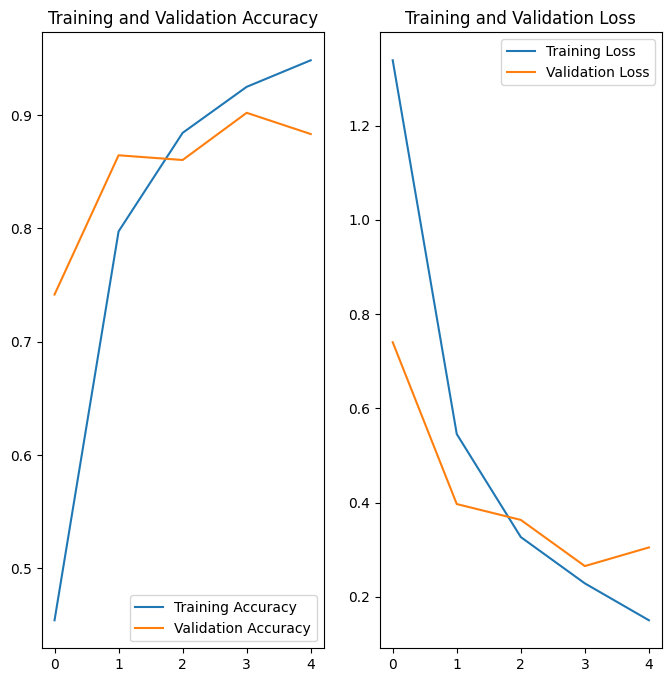

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Saving the Model
Save the trained model to a file for later use.


In [87]:
save_model(model, 'mango_leaf_disease_model.h5')
print("Model Saved")

# Load the saved model from the file
model = tf.keras.models.load_model('mango_leaf_disease_model.h5')
print("Model loaded!")


C:\Users\MSI 15\AppData\Local\Temp\ipykernel_28096\1148261965.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'mango_leaf_disease_model.h5')


Model Saved
Model loaded!


## Testing the Model on New Images
In this section, we will load new mango leaf images, preprocess them, and use the trained model to predict the class with confidence.


In [88]:
from PIL import Image  # Ensure this is imported

def load_and_predict(image_path, model, class_names, img_height=180, img_width=180):
    # Load the image using PIL and convert to a NumPy array
    img = Image.open(image_path)  # Use PIL to open the image
    img = np.array(img)  # Convert to NumPy array
    
    # Resize and cast to float32
    img = tf.image.resize(img, [img_height, img_width])  # Resize to target size
    img = tf.cast(img, tf.float32)  # Cast to float32
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get predictions
    predictions = model.predict(img)
    probabilities = tf.nn.softmax(predictions[0]).numpy()  # Apply softmax and convert to NumPy
    
    # Get the predicted class and confidence
    predicted_class = class_names[np.argmax(probabilities)]
    confidence = np.max(probabilities) * 100  # Convert to percentage
    
    return predicted_class, confidence


## Testing with a Sample Image
Now, let's test the model with a sample image from the dataset (or a new image). You can specify the path to any leaf image you want to test.


In [89]:
# Replace this with the path to your test image
test_image_path = "./test/Anthracnose/1.jpg"  # Example path

# Call the function to make a prediction
predicted_class, confidence = load_and_predict(test_image_path, model, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


1/1 [==============================] - 0s 54ms/step
Predicted Class: Anthracnose
Confidence: 99.96%


## Displaying the Image
Let's visualize the image alongside the predicted class and confidence.

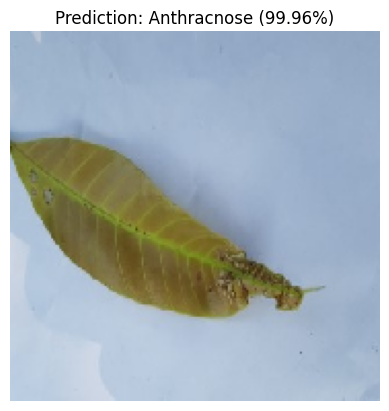

In [90]:
# Display the test image with prediction details
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()
